In [100]:
import numpy as np
import os
import wget
import torch
import random

torch.manual_seed(0)
random.seed(0)
url = "http://amlbook.com/data/zip/zip.train"
if not os.path.exists("zip.train"):
    wget.download(url)
train_data = np.loadtxt("zip.train")
train_data

array([[ 6.   , -1.   , -1.   , ..., -1.   , -1.   , -1.   ],
       [ 5.   , -1.   , -1.   , ..., -0.671, -0.828, -1.   ],
       [ 4.   , -1.   , -1.   , ..., -1.   , -1.   , -1.   ],
       ...,
       [ 3.   , -1.   , -1.   , ..., -1.   , -1.   , -1.   ],
       [ 0.   , -1.   , -1.   , ..., -1.   , -1.   , -1.   ],
       [ 1.   , -1.   , -1.   , ..., -1.   , -1.   , -1.   ]])

In [101]:
from torch.utils.data import Dataset, DataLoader
from torch import nn


class Dataset11(Dataset):
    def __init__(self):
        self.data = train_data[-256:, :]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.data[idx]


dataset11 = Dataset11()
train_dataloader11 = DataLoader(dataset11, batch_size=len(dataset11))

device = "cuda" if torch.cuda.is_available() else "cpu"


class AutoEncoderNet(nn.Module):
    def __init__(self, input, output):
        super().__init__()
        self.encoder = nn.Linear(input, output, bias=True)
        self.encoder.bias = init_weight(output, 1, (output,))
        self.encoder.weight = init_weight(output, 1, (output, input))
        self.decoder = nn.Linear(output, input, bias=True)
        self.decoder.bias = init_weight(output, 2, (input,))
        self.decoder.weight = init_weight(output, 2, (input, output))

    def forward(self, x):
        return self.decoder(self.encoder(x))


def init_weight(d, layout, size):
    u = np.sqrt(6 / (1 + d ** (layout - 1) + d ** layout))
    return torch.nn.Parameter(torch.distributions.Uniform(-u, u).sample(size))


def train(dataloader, model, loss_fn, optimizer):
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


def test(dataloader, model):
    model.eval()
    test_loss = 0
    size = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            size += 1
    test_loss /= size
    return test_loss


loss_fn = nn.MSELoss()


loss 123.16359311329029
loss nan
loss nan



loss 17.102285905445818
loss 1.274152653875447
loss 0.6773543672918387



loss 5.8425345940594955
loss 0.7529328714555832
loss 0.544631362251127



loss 2.854938926683514
loss 0.5327042639153196
loss 0.38107707358430243



loss 1.4051064881230875
loss 0.32847969144344497
loss 0.2463997775191862



loss 0.9611609125774777
loss 0.2256311617579536
loss 0.1667637014748846

[1, 2, 3, 4, 5, 6] [nan, 0.5940757762741157, 0.45529723065501154, 0.32037121781200656, 0.20994051997830185, 0.13984576655315456]


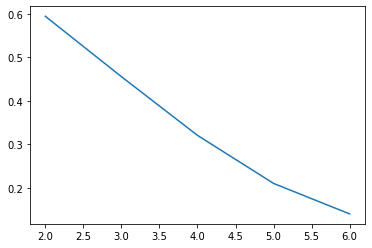

In [102]:
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt


def experiment(d):
    model = AutoEncoderNet(train_data.shape[1], d).double().to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)
    epochs = 300
    for t in tqdm(range(epochs)):
        train(train_dataloader11, model, loss_fn, optimizer)
        if t % 100 == 0:
            print("loss", test(train_dataloader11, model))
    return test(train_dataloader11, model)


x_show = []
e_ins = []
for num in range(1, 7):
    d = 2 ** num
    e_in = experiment(d)
    x_show.append(num)
    e_ins.append(e_in)

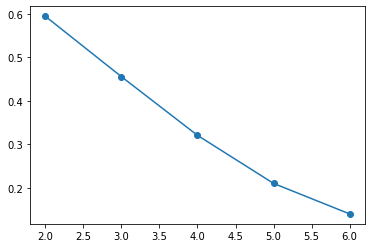

In [104]:
plt.plot(x_show, e_ins, marker='o')
plt.show()
